In [1]:
import ast
import numpy as np
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import SAGEConv

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def CalculateWeight(num_messages, viral_strenght):
    if viral_strenght == 0:
        viral_strenght = 0.001
    else:
        viral_strenght = viral_strenght / 1000

    return num_messages * (viral_strenght)

def CreateMessageGraph(file_path):
    data = pd.read_csv(file_path)
    
    data['group_list'] = data['group_list'].apply(ast.literal_eval)
    viralStrengthDict = data.set_index('id')['viral_strenght'].to_dict()

    groupDict = {}

    for _, row in data.iterrows():
        user_id = row['id']
        group_list = row['group_list']
        for group in group_list:
            for group_id, message_count in group.items():
                if group_id not in groupDict:
                    groupDict[group_id] = []
                groupDict[group_id].append((user_id, message_count))

    G = nx.DiGraph()

    for _, row in data.iterrows():
        node_id = row['id']
        node_attributes = row.drop('group_list').to_dict()
        
        G.add_node(node_id, **node_attributes)

    for group_id, users in groupDict.items():
        for i, (user_i, messages_i) in enumerate(users):
            for user_j, messages_j in users:
                if user_i != user_j:
                    if G.has_edge(user_i, user_j):
                        G[user_i][user_j]['weight'] += (CalculateWeight(messages_i, viralStrengthDict.get(user_i)))
                    else:
                        G.add_edge(user_i, user_j, weight = (CalculateWeight(messages_i, viralStrengthDict.get(user_i))))

    return G

def ExtractNodeFeatures(G):
    features = []
    for node in G.nodes():
        node_data = G.nodes[node]
        vector = [
            node_data.get('groups'),
            node_data.get('number_of_messages'),
            node_data.get('texts'),
            node_data.get('text_ratio'),
            node_data.get('midia'),
            node_data.get('midia_ratio'), 
            node_data.get('virals'),
            node_data.get('repeated_messages'),
            node_data.get('strenght'),
            node_data.get('viral_strenght')
        ]
        features.append(vector)
    return features

In [3]:
def CreateGraphSplits(G, X, y, val_ratio=0.15, test_ratio=0.15, random_state=42):
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    
    num_nodes = G.number_of_nodes()
    node_indices = np.arange(num_nodes)
    
    adj_matrix = nx.to_numpy_array(G)

    n_clusters = min(20, num_nodes // 50)
    node_features = X.numpy()
    clustering = KMeans(n_clusters=n_clusters, random_state=random_state).fit(node_features)
    node_clusters = clustering.labels_

    unique_clusters = np.unique(node_clusters)
    
    train_idx, val_idx, test_idx = [], [], []
    
    for cluster in unique_clusters:
        cluster_mask = node_clusters == cluster
        cluster_indices = node_indices[cluster_mask]
        
        for label in torch.unique(y):
            label_mask = y[cluster_indices] == label
            label_indices = cluster_indices[label_mask.numpy()]
            
            if len(label_indices) == 0:
                continue
                
            np.random.shuffle(label_indices)
            
            n_test = max(1, int(test_ratio * len(label_indices)))
            n_val = max(1, int(val_ratio * len(label_indices)))
            
            if n_test + n_val > len(label_indices):
                if len(label_indices) > 1:
                    n_test = 1
                    n_val = 1 if len(label_indices) > 2 else 0
                else:
                    n_test = 1
                    n_val = 0
            
            test_idx.extend(label_indices[:n_test])
            val_idx.extend(label_indices[n_test:n_test+n_val])
            train_idx.extend(label_indices[n_test+n_val:])
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    assert not torch.any(train_mask & val_mask)
    assert not torch.any(train_mask & test_mask)
    assert not torch.any(val_mask & test_mask)
    
    print(f"Train: {train_mask.sum().item()} nodes ({train_mask.sum().item()/num_nodes:.2%})")
    print(f"Val: {val_mask.sum().item()} nodes ({val_mask.sum().item()/num_nodes:.2%})")
    print(f"Test: {test_mask.sum().item()} nodes ({test_mask.sum().item()/num_nodes:.2%})")
    
    class_train = torch.bincount(y[train_mask])
    class_val = torch.bincount(y[val_mask])
    class_test = torch.bincount(y[test_mask])
    
    print(f"Class distribution - Train: {class_train.numpy()}")
    print(f"Class distribution - Val: {class_val.numpy()}")
    print(f"Class distribution - Test: {class_test.numpy()}")
    
    return train_mask, val_mask, test_mask

def TrainTestSplit(indices, test_size, random_state, stratify=None):
    from sklearn.model_selection import train_test_split as sklearn_split
    return sklearn_split(indices, test_size=test_size, random_state=random_state, stratify=stratify)

In [4]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate):
        super(GraphSAGE, self).__init__()
        
        self.conv1 = SAGEConv(input_dim, hidden_dim1)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim1)
        
        self.conv2 = SAGEConv(hidden_dim1, hidden_dim2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim2)
        
        self.conv3 = SAGEConv(hidden_dim2, output_dim)
        
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [5]:
def FindBestThreshold(y_true, positive_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, positive_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5
    
    return best_threshold

def EvaluateModel(model, data, mask=None, threshold=None, dataset_name="Dataset", return_metrics=False):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        y_prob = torch.exp(output)[:, 1].cpu().numpy()
        y_true = data.y.cpu().numpy()
        
        if mask is not None:
            mask_np = mask.cpu().numpy()
            y_true = y_true[mask_np]
            y_prob = y_prob[mask_np]
        
        if threshold is None:
            threshold = FindBestThreshold(y_true, y_prob)
            
        y_pred = (y_prob >= threshold).astype(int)
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        fp = conf_matrix[0][1] if conf_matrix.shape[0] > 1 and conf_matrix.shape[1] > 1 else 0
        fn = conf_matrix[1][0] if conf_matrix.shape[0] > 1 and conf_matrix.shape[1] > 1 else 0
        
        total_positives = sum(y_true)
        true_positives = sum(1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1)
        percentage_identified = (true_positives / total_positives * 100) if total_positives > 0 else 0.0
        
        print(f"\nEvaluation on {dataset_name}:")
        print(f"  Accuracy: {accuracy:.6f}")
        print(f"  Precision: {precision:.6f}")
        print(f"  Recall: {recall:.6f}")
        print(f"  F1 Score: {f1:.6f}")
        print(f"  AUC: {auc:.6f}")
        print(f"  False Positives: {fp}")
        print(f"  False Negatives: {fn}")
        print(f"  Percentage of misinformers identified: {percentage_identified:.5f}%")
        
        if return_metrics:
            return {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'fp': fp,
                'fn': fn,
                'percentage_identified': percentage_identified,
                'threshold': threshold
            }

In [6]:
DEFAULT_HIDDEN_DIM1 = 64
DEFAULT_HIDDEN_DIM2 = 32
DEFAULT_DROPOUT_RATE = 0.3
DEFAULT_LEARNING_RATE = 0.05
DEFAULT_WEIGHT_DECAY = 1e-6
DEFAULT_EPOCHS = 150
DEFAULT_EARLY_STOPPING_PATIENCE = 20

def KFoldCrossValidation(data, k=5, epochs=DEFAULT_EPOCHS, hidden_dim1=DEFAULT_HIDDEN_DIM1, 
                         hidden_dim2=DEFAULT_HIDDEN_DIM2, dropout_rate=DEFAULT_DROPOUT_RATE, 
                         lr=DEFAULT_LEARNING_RATE, weight_decay=DEFAULT_WEIGHT_DECAY, 
                         early_stopping_patience=DEFAULT_EARLY_STOPPING_PATIENCE):

    node_indices = np.arange(data.num_nodes)
    labels = data.y.numpy()
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    fold_metrics = []
    
    for fold, (train_val_idx, test_idx) in enumerate(skf.split(node_indices, labels)):
        print(f"\n{'='*50}")
        print(f"Fold {fold+1}/{k}")
        print(f"{'='*50}")
        
        train_idx, val_idx = TrainTestSplit(train_val_idx, test_size=0.2, random_state=42, 
                                           stratify=labels[train_val_idx])
        
        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True
        
        print(f"Train: {train_mask.sum()} nodes")
        print(f"Val: {val_mask.sum()} nodes")
        print(f"Test: {test_mask.sum()} nodes")
        
        input_dim = data.x.size(1)
        output_dim = 2
        
        model = GraphSAGE(input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        
        class_counts = torch.bincount(data.y)
        class_weights = torch.tensor(len(data.y) / (len(class_counts) * class_counts.float()))
        criterion = torch.nn.NLLLoss(weight=class_weights)
        
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(data.x, data.edge_index)
            loss = criterion(output[train_mask], data.y[train_mask])
            loss.backward()
            optimizer.step()
            
            model.eval()
            with torch.no_grad():
                output = model(data.x, data.edge_index)
                val_loss = criterion(output[val_mask], data.y[val_mask])

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}")
                break
                
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        
        if best_model_state:
            model.load_state_dict(best_model_state)
            
        metrics = EvaluateModel(model, data, test_mask, dataset_name=f"Fold {fold+1} Test Set", return_metrics=True)
        fold_metrics.append(metrics)
        
    avg_metrics = {}
    for metric in fold_metrics[0].keys():
        values = [fold[metric] for fold in fold_metrics]
        avg_metrics[metric] = sum(values) / len(values)
        
    print("\n" + "="*50)
    print("Average Performance Across All Folds:")
    print("="*50)
    print(f"  Accuracy: {avg_metrics['accuracy']:.6f}")
    print(f"  Precision: {avg_metrics['precision']:.6f}")
    print(f"  Recall: {avg_metrics['recall']:.6f}")
    print(f"  F1 Score: {avg_metrics['f1']:.6f}")
    print(f"  AUC: {avg_metrics['auc']:.6f}")
    print(f"  Avg False Positives: {avg_metrics['fp']:.2f}")
    print(f"  Avg False Negatives: {avg_metrics['fn']:.2f}")
    print(f"  Avg % Misinformers Identified: {avg_metrics['percentage_identified']:.5f}%")
    
    return {
        'avg_metrics': avg_metrics,
        'fold_metrics': fold_metrics
    }

In [7]:
csv_file_path = 'users_selected_features.csv'
graph = CreateMessageGraph(csv_file_path)
print(f'Number of nodes: {graph.number_of_nodes()}')
print(f'Number of edges: {graph.number_of_edges()}')

pyg_data = from_networkx(graph)
node_features = ExtractNodeFeatures(graph)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(node_features)
X = torch.tensor(X_normalized, dtype=torch.float)

labels = torch.tensor([graph.nodes[node]['disinformer'] for node in graph.nodes()], dtype=torch.long)

data = Data(x=X, edge_index=pyg_data.edge_index, y=labels)

train_mask, val_mask, test_mask = CreateGraphSplits(graph, X, labels)

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

Number of nodes: 5364
Number of edges: 1125326
Train: 3758 nodes (70.06%)
Val: 800 nodes (14.91%)
Test: 806 nodes (15.03%)
Class distribution - Train: [3672   86]
Class distribution - Val: [779  21]
Class distribution - Test: [781  25]


In [8]:
input_dim = X.size(1)
hidden_dim1 = DEFAULT_HIDDEN_DIM1
hidden_dim2 = DEFAULT_HIDDEN_DIM2
output_dim = 2
dropout_rate = DEFAULT_DROPOUT_RATE
lr = DEFAULT_LEARNING_RATE
weight_decay = DEFAULT_WEIGHT_DECAY

print("\nStarting k-fold cross-validation...")
cv_results = KFoldCrossValidation(data, k=5, epochs=300, hidden_dim1=hidden_dim1,
                                 hidden_dim2=hidden_dim2, dropout_rate=dropout_rate, 
                                 lr=lr, weight_decay=weight_decay)


Starting k-fold cross-validation...

Fold 1/5
Train: 3432 nodes
Val: 859 nodes
Test: 1073 nodes


C:\Users\User\AppData\Local\Temp\ipykernel_17388\3002487112.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(len(data.y) / (len(class_counts) * class_counts.float()))


Epoch 0, Train Loss: 0.6303, Val Loss: 0.3079
Epoch 10, Train Loss: 0.0429, Val Loss: 0.1943
Epoch 20, Train Loss: 0.0809, Val Loss: 0.1478
Epoch 30, Train Loss: 0.0430, Val Loss: 0.0335
Epoch 40, Train Loss: 0.0302, Val Loss: 0.0362
Epoch 50, Train Loss: 0.0302, Val Loss: 0.0300
Epoch 60, Train Loss: 0.0142, Val Loss: 0.0320
Epoch 70, Train Loss: 0.0201, Val Loss: 0.0233
Epoch 80, Train Loss: 0.0213, Val Loss: 0.0273
Epoch 90, Train Loss: 0.0106, Val Loss: 0.0165
Epoch 100, Train Loss: 0.0199, Val Loss: 0.0272
Epoch 110, Train Loss: 0.0122, Val Loss: 0.0189
Early stopping at epoch 111

Evaluation on Fold 1 Test Set:
  Accuracy: 1.000000
  Precision: 1.000000
  Recall: 1.000000
  F1 Score: 1.000000
  AUC: 1.000000
  False Positives: 0
  False Negatives: 0
  Percentage of misinformers identified: 100.00000%

Fold 2/5
Train: 3432 nodes
Val: 859 nodes
Test: 1073 nodes


C:\Users\User\AppData\Local\Temp\ipykernel_17388\3002487112.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(len(data.y) / (len(class_counts) * class_counts.float()))


Epoch 0, Train Loss: 0.5533, Val Loss: 0.2860
Epoch 10, Train Loss: 0.0518, Val Loss: 0.1250
Epoch 20, Train Loss: 0.0378, Val Loss: 0.0571
Epoch 30, Train Loss: 0.0168, Val Loss: 0.0320
Epoch 40, Train Loss: 0.0300, Val Loss: 0.0196
Epoch 50, Train Loss: 0.0172, Val Loss: 0.0134
Epoch 60, Train Loss: 0.0143, Val Loss: 0.0284
Early stopping at epoch 70

Evaluation on Fold 2 Test Set:
  Accuracy: 0.996272
  Precision: 0.866667
  Recall: 1.000000
  F1 Score: 0.928571
  AUC: 0.999486
  False Positives: 4
  False Negatives: 0
  Percentage of misinformers identified: 100.00000%

Fold 3/5
Train: 3432 nodes
Val: 859 nodes
Test: 1073 nodes


C:\Users\User\AppData\Local\Temp\ipykernel_17388\3002487112.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(len(data.y) / (len(class_counts) * class_counts.float()))


Epoch 0, Train Loss: 0.6881, Val Loss: 0.4379
Epoch 10, Train Loss: 0.0783, Val Loss: 0.1273
Epoch 20, Train Loss: 0.0280, Val Loss: 0.0665
Epoch 30, Train Loss: 0.0435, Val Loss: 0.0298
Epoch 40, Train Loss: 0.0215, Val Loss: 0.0160
Epoch 50, Train Loss: 0.0241, Val Loss: 0.0137
Epoch 60, Train Loss: 0.0162, Val Loss: 0.0114
Epoch 70, Train Loss: 0.0240, Val Loss: 0.0099
Epoch 80, Train Loss: 0.0106, Val Loss: 0.0127
Early stopping at epoch 86

Evaluation on Fold 3 Test Set:
  Accuracy: 0.999068
  Precision: 0.964286
  Recall: 1.000000
  F1 Score: 0.981818
  AUC: 0.999894
  False Positives: 1
  False Negatives: 0
  Percentage of misinformers identified: 100.00000%

Fold 4/5
Train: 3432 nodes
Val: 859 nodes
Test: 1073 nodes


C:\Users\User\AppData\Local\Temp\ipykernel_17388\3002487112.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(len(data.y) / (len(class_counts) * class_counts.float()))


Epoch 0, Train Loss: 0.5677, Val Loss: 0.2654
Epoch 10, Train Loss: 0.0591, Val Loss: 0.1726
Epoch 20, Train Loss: 0.0447, Val Loss: 0.0801
Epoch 30, Train Loss: 0.0208, Val Loss: 0.0145
Epoch 40, Train Loss: 0.0203, Val Loss: 0.0110
Epoch 50, Train Loss: 0.0265, Val Loss: 0.0142
Epoch 60, Train Loss: 0.0140, Val Loss: 0.0089
Epoch 70, Train Loss: 0.0176, Val Loss: 0.0093
Epoch 80, Train Loss: 0.0140, Val Loss: 0.0107
Epoch 90, Train Loss: 0.0271, Val Loss: 0.0075
Epoch 100, Train Loss: 0.0161, Val Loss: 0.0101
Early stopping at epoch 107

Evaluation on Fold 4 Test Set:
  Accuracy: 0.999068
  Precision: 0.964286
  Recall: 1.000000
  F1 Score: 0.981818
  AUC: 0.999965
  False Positives: 1
  False Negatives: 0
  Percentage of misinformers identified: 100.00000%

Fold 5/5
Train: 3433 nodes
Val: 859 nodes
Test: 1072 nodes


C:\Users\User\AppData\Local\Temp\ipykernel_17388\3002487112.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(len(data.y) / (len(class_counts) * class_counts.float()))


Epoch 0, Train Loss: 0.5923, Val Loss: 0.3559
Epoch 10, Train Loss: 0.1108, Val Loss: 0.1493
Epoch 20, Train Loss: 0.0376, Val Loss: 0.0751
Epoch 30, Train Loss: 0.0255, Val Loss: 0.0415
Epoch 40, Train Loss: 0.0123, Val Loss: 0.0318
Epoch 50, Train Loss: 0.0223, Val Loss: 0.0351
Epoch 60, Train Loss: 0.0085, Val Loss: 0.0284
Early stopping at epoch 65

Evaluation on Fold 5 Test Set:
  Accuracy: 0.998134
  Precision: 1.000000
  Recall: 0.923077
  F1 Score: 0.960000
  AUC: 0.999448
  False Positives: 0
  False Negatives: 2
  Percentage of misinformers identified: 92.30769%

Average Performance Across All Folds:
  Accuracy: 0.998509
  Precision: 0.959048
  Recall: 0.984615
  F1 Score: 0.970442
  AUC: 0.999759
  Avg False Positives: 1.20
  Avg False Negatives: 0.40
  Avg % Misinformers Identified: 98.46154%


In [9]:
print("\nTraining final model on full training set...")

model = GraphSAGE(input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

class_counts = torch.bincount(data.y)
total_samples = len(data.y)
class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts.float()))
criterion = torch.nn.NLLLoss(weight=class_weights)

best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
FINAL_EARLY_STOPPING_PATIENCE = 100

train_losses = []
val_losses = []

FINAL_EPOCHS = 400
for epoch in range(FINAL_EPOCHS):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        val_loss = criterion(output[data.val_mask], data.y[data.val_mask])
    
    val_losses.append(val_loss.item())
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= FINAL_EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

if best_model_state:
    model.load_state_dict(best_model_state)


Training final model on full training set...


C:\Users\User\AppData\Local\Temp\ipykernel_17388\3755835318.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(total_samples / (len(class_counts) * class_counts.float()))


Epoch 0, Train Loss: 0.7822, Val Loss: 0.2901
Epoch 10, Train Loss: 0.0474, Val Loss: 0.1014
Epoch 20, Train Loss: 0.0561, Val Loss: 0.0676
Epoch 30, Train Loss: 0.0237, Val Loss: 0.0223
Epoch 40, Train Loss: 0.0244, Val Loss: 0.1350
Epoch 50, Train Loss: 0.0171, Val Loss: 0.0697
Epoch 60, Train Loss: 0.0305, Val Loss: 0.0876
Epoch 70, Train Loss: 0.0113, Val Loss: 0.0680
Epoch 80, Train Loss: 0.0089, Val Loss: 0.1544
Epoch 90, Train Loss: 0.0148, Val Loss: 0.1607
Epoch 100, Train Loss: 0.0111, Val Loss: 0.1430
Epoch 110, Train Loss: 0.0091, Val Loss: 0.2390
Epoch 120, Train Loss: 0.0118, Val Loss: 0.0252
Epoch 130, Train Loss: 0.0320, Val Loss: 0.0119
Epoch 140, Train Loss: 0.0111, Val Loss: 0.0125
Epoch 150, Train Loss: 0.0244, Val Loss: 0.1743
Epoch 160, Train Loss: 0.0284, Val Loss: 0.1725
Epoch 170, Train Loss: 0.0202, Val Loss: 0.1466
Epoch 180, Train Loss: 0.0118, Val Loss: 0.2281
Epoch 190, Train Loss: 0.0189, Val Loss: 0.0076
Epoch 200, Train Loss: 0.0082, Val Loss: 0.0145
Epo

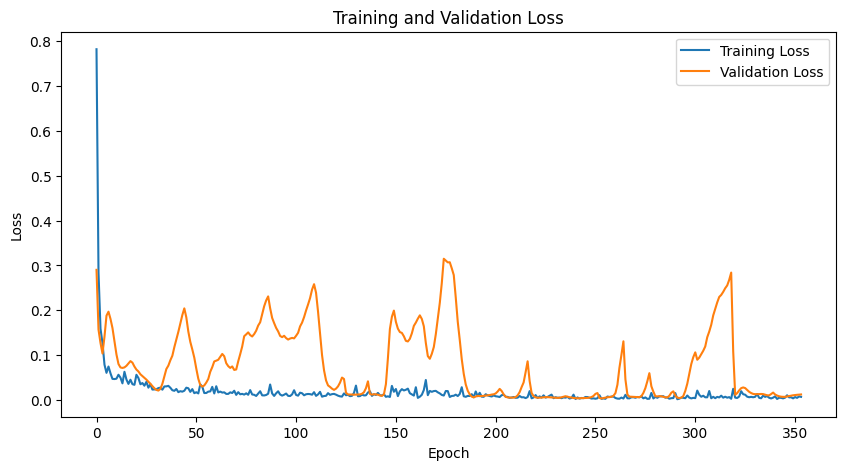

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('graphsage_training_curves.png')
plt.show()

In [11]:
val_metrics = EvaluateModel(model, data, data.val_mask, dataset_name="Validation Set", return_metrics=True)

test_metrics = EvaluateModel(model, data, data.test_mask, dataset_name="Test Set", return_metrics=True)

full_metrics = EvaluateModel(model, data, None, dataset_name="Complete Set", return_metrics=True)


Evaluation on Validation Set:
  Accuracy: 0.997500
  Precision: 0.913043
  Recall: 1.000000
  F1 Score: 0.954545
  AUC: 0.999633
  False Positives: 2
  False Negatives: 0
  Percentage of misinformers identified: 100.00000%

Evaluation on Test Set:
  Accuracy: 0.998759
  Precision: 1.000000
  Recall: 0.960000
  F1 Score: 0.979592
  AUC: 0.999898
  False Positives: 0
  False Negatives: 1
  Percentage of misinformers identified: 96.00000%

Evaluation on Complete Set:
  Accuracy: 0.999254
  Precision: 0.977612
  Recall: 0.992424
  F1 Score: 0.984962
  AUC: 0.999906
  False Positives: 3
  False Negatives: 1
  Percentage of misinformers identified: 99.24242%
